In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42

In [3]:
df_train = pd.read_csv('data/main_task.csv')
df_test = pd.read_csv('data/kaggle_task.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [4]:
df_preproc = data.copy()


In [5]:
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
# data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')

In [6]:
df_preproc['Number of Reviews'].fillna(0, inplace=True)
df_preproc['Cuisine Style'].fillna(0, inplace=True)


In [7]:
df_preproc['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [8]:
df_preproc['Cuisine Style'] = df_preproc['Cuisine Style'].str[2:-2].str.split("', '")

In [9]:
#Очистим столбец Restaurant_id (сделаем только из цифр)
df_preproc['Restaurant_id'] = df_preproc['Restaurant_id'].apply(lambda x : int(x.split('_')[1]))

In [10]:
def price_range_rating (price_range_string):
    if "$$$$" in str(price_range_string):
        return 3
    elif "$$ - $$$" in str(price_range_string):
        return 2
    elif "$" in str(price_range_string):
        return 1
    elif str(0) in str(price_range_string):
        return 0

df_preproc['Price Range'] = df_preproc['Price Range'].apply(price_range_rating)
#Делаем dummies на основе изменного Price Range
df_preproc = pd.get_dummies(df_preproc, columns=['Price Range', ], dummy_na=True)

In [11]:
#Добавим население из Google
city = {
    'London': {
        'population': 8908081,
        'is_capital': 1,
        'country': 'United Kingdom',
        'cuisine': None,
    },
    'Paris': {
        'population':2240621,
        'is_capital': 1,
        'country': 'France',
        'cuisine': None,
    },
    'Madrid': {
        'population': 3155360,
        'is_capital': 1,
        'country': 'France',
        'cuisine': None,
    },
    'Barcelona': {
        'population': 1593075,
        'is_capital': 0,
        'country': 'Spain',
        'cuisine': None,
    },
    'Berlin': {
        'population': 3326002,
        'is_capital': 1,
        'country': 'Germainy',
        'cuisine': None,
    },
    'Milan': {
        'population': 1331586,
        'is_capital': 0,
        'country': 'Italy',
        'cuisine': None,
    },
    'Rome': {
        'population': 2870493,
        'is_capital': 1,
        'country': 'Italy',
        'cuisine': None,
    },
    'Prague': {
        'population': 1272690,
        'is_capital': 1,
        'country': 'Czech Republic',
        'cuisine': None,
    },
    'Lisbon': {
        'population': 547733,
        'is_capital': 1,
        'country': 'Portugal',
        'cuisine': None,
    },
    'Vienna': {
        'population': 1765649,
        'is_capital': 1,
        'country': 'Austria',
        'cuisine': None,
    },
    'Amsterdam': {
        'population': 825080,
        'is_capital': 1,
        'country': 'Netherlands',
        'cuisine': None,
    },
    'Brussels': {
        'population': 144784,
        'is_capital': 1,
        'country': 'Belgium',
        'cuisine': None,
    },
    'Hamburg': {
        'population': 1718187,
        'is_capital': 0,
        'country': 'Germainy',
        'cuisine': None,
    },
    'Munich': {
        'population': 1364920,
        'is_capital': 0,
        'country': 'Germainy',
        'cuisine': None,
    },
    'Lyon': {
        'population': 496343,
        'is_capital': 0,
        'country': 'France',
        'cuisine': None,
    },
    'Stockholm': {
        'population': 1981263,
        'is_capital': 1,
        'country': 'Sweden',
        'cuisine': None,
    },
    'Budapest': {
        'population': 1744665,
        'is_capital': 1,
        'country': 'Hungary',
        'cuisine': None,
    },
    'Warsaw': {
        'population': 1720398,
        'is_capital': 1,
        'country': 'Poland',
        'cuisine': None,
    },
    'Dublin': {
        'population': 506211,
        'is_capital': 1,
        'country': 'Ireland',
        'cuisine': None,
    } ,
    'Copenhagen': {
        'population': 1246611,
        'is_capital': 1,
        'country': 'Denmark',
        'cuisine': None,
    },
    'Athens': {
        'population': 3168846,
        'is_capital': 1,
        'country': 'Greece',
        'cuisine': None,
    },
    'Edinburgh': {
        'population': 476100,
        'is_capital': 1,
        'country': 'Scotland',
        'cuisine': None,
    },
    'Zurich': {
        'population': 402275,
        'is_capital': 1,
        'country': 'Switzerland',
        'cuisine': None,
    },
    'Oporto': {
        'population': 221800,
        'is_capital': 0,
        'country': 'Portugal',
        'cuisine': None,
    },
    'Geneva': {
        'population': 196150,
        'is_capital': 0,
        'country': 'Switzerland',
        'cuisine': None,
    },
    'Krakow': {
        'population': 756183,
        'is_capital': 0,
        'country': 'Poland',
        'cuisine': None,
    },
    'Oslo': {
        'population': 673469,
        'is_capital': 1,
        'country': 'Norway',
        'cuisine': None,
    },
    'Helsinki': {
        'population': 574579,
        'is_capital': 1,
        'country': 'Finland',
        'cuisine': None,
    },
    'Bratislava': {
        'population': 413192,
        'is_capital': 1,
        'country': 'Slovakia',
        'cuisine': None,
    },
    'Luxembourg': {
        'population': 576249,
        'is_capital': 1,
        'country': 'Luxembourg',
        'cuisine': None,
    },
    'Ljubljana': {
        'population': 277554,
        'is_capital': 1,
        'country': 'Slovenia',
        'cuisine': None,
    }
}

df_preproc['population'] = df_preproc['City'].apply(lambda x: city[x]['population'])
df_preproc['is_capital'] = df_preproc['City'].apply(lambda x: city[x]['is_capital'])
df_preproc['country'] = df_preproc['City'].apply(lambda x: city[x]['country'])
df_preproc = pd.get_dummies(df_preproc, columns=['country'], dummy_na=True)

In [12]:
print(df_preproc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           50000 non-null  int64  
 1   City                    50000 non-null  object 
 2   Cuisine Style           38410 non-null  object 
 3   Ranking                 50000 non-null  float64
 4   Number of Reviews       50000 non-null  float64
 5   Reviews                 49998 non-null  object 
 6   URL_TA                  50000 non-null  object 
 7   ID_TA                   50000 non-null  object 
 8   sample                  50000 non-null  int64  
 9   Rating                  50000 non-null  float64
 10  Price Range_1.0         50000 non-null  uint8  
 11  Price Range_2.0         50000 non-null  uint8  
 12  Price Range_3.0         50000 non-null  uint8  
 13  Price Range_nan         50000 non-null  uint8  
 14  population              50000 non-null

In [13]:
count = df_preproc['City'].value_counts()
df_preproc['restaurant_in_city'] = df_preproc['City'].apply(lambda x : count[x])
df_preproc = pd.get_dummies(df_preproc, columns=['City'], dummy_na=True)

In [14]:
object_columns = [s for s in df_preproc.columns if df_preproc[s].dtypes == 'object']
df_preproc.drop(object_columns, axis = 1, inplace=True)

In [15]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [16]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 67), (40000, 67), (40000, 66), (32000, 66), (8000, 66))

In [18]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [19]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [20]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [21]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.209654375


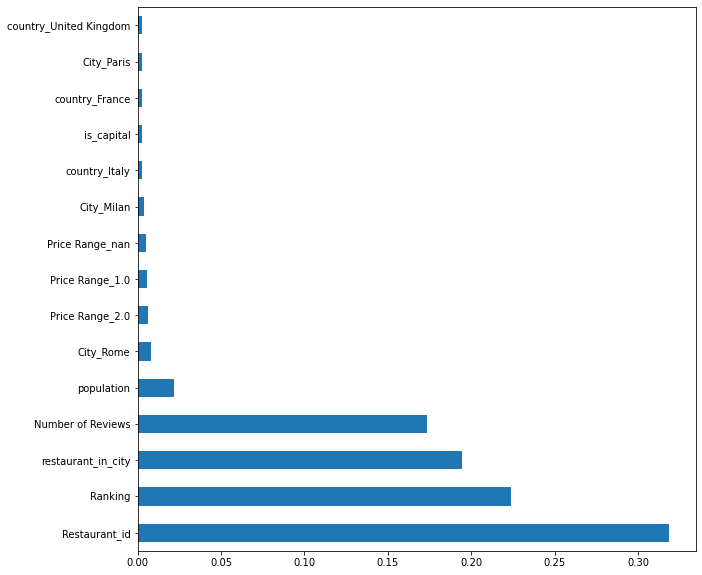

In [22]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
